# Análise de RNA-Seq usando a linguagem R

Vamos aqui analisar os genes diferencialmente expressos em células de glândulas mamárias de camundongos fêmeas em duas situações: grávidas e lactantes.
O desenho do experimento original tem, células dos subtipos basal e luminal em três condições: virgens, grávidas e lactantes.
O artigo original do trabalho (Fu, 2015) pode ser encontrado em https://www.ncbi.nlm.nih.gov/pubmed/25730472.
Os dados do experimento estão depositados em https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE60450.

Fu NY, Rios AC, Pal B, Soetanto R et al. EGF-mediated induction of Mcl-1 at the switch to lactation is essential for alveolar cell survival. Nat Cell Biol 2015 Apr;17(4):365-75.

### Passo 01: Instalar os pacotes R necessários

In [38]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(c("limma","edgeR","Glimma","data.table","org.Mm.eg.db", "statmod"))

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)
Installing package(s) 'limma', 'edgeR', 'Glimma', 'data.table', 'org.Mm.eg.db',
  'statmod'
Warning message in install.packages(...):
“installation of package ‘edgeR’ had non-zero exit status”Warning message in install.packages(...):
“installation of package ‘Glimma’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


### Passo 02: Carregar os pacotes R instalados

In [39]:
suppressMessages(library(limma))
suppressMessages(library(Glimma))
suppressMessages(library(edgeR))
suppressMessages(library(data.table))
suppressMessages(library(org.Mm.eg.db))

### Passo 03: Download e leitura dos arquivos
Os arquivos são baixados e lidos como um dataframe chamado dados

In [40]:
# AMOSTRAS
# Download das amostras
url <- "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE60nnn/GSE60450/suppl/GSE60450_Lactation-GenewiseCounts.txt.gz"
download.file(url, "GSE60450_Lactation.txt.gz")
# Ler tabela de gene counts id dos genes do NCBI Entrez
dados <- read.delim("GSE60450_Lactation.txt.gz", row.names="EntrezGeneID", stringsAsFactors = TRUE)
colnames(dados) <- substring(colnames(dados),1,7)# nomes de colunas abreviados para 7 caracteres
dados <- dados[,-(1)] # remove a columna 1: Length/
dim(dados) # mostrar as dimensoes do dataframe dados
head(dados) # mostrar primeiras linhas do dataframe dados

[1] 27179    12

,MCL1.DG,MCL1.DH,MCL1.DI,MCL1.DJ,MCL1.DK,MCL1.DL,MCL1.LA,MCL1.LB,MCL1.LC,MCL1.LD,MCL1.LE,MCL1.LF
497097,438,300,65,237,354,287,0,0,0,0,0,0
100503874,1,0,1,1,0,4,0,0,0,0,0,0
100038431,0,0,0,0,0,0,0,0,0,0,0,0
19888,1,1,0,0,0,0,10,3,10,2,0,0
20671,106,182,82,105,43,82,16,25,18,8,3,10
27395,309,234,337,300,290,270,560,464,489,328,307,342


### Passo 04: criar uma dataframe auxiliar com os dados do desenho do experimento

In [41]:
# Informação das amostras do experimento para classificacao posterior
column_head <- c("Arquivo", "Amostra", "Celula", "Status")
column_01 <- c("MCL1.LA_BC2CTUACXX_GATCAG_L001_R1",    "MCL1.LA",    "basal",   "virgem")
column_02 <- c("MCL1.LB_BC2CTUACXX_TGACCA_L001_R1",    "MCL1.LB",  "luminal",   "virgem")
column_03 <- c("MCL1.LC_BC2CTUACXX_GCCAAT_L001_R1",    "MCL1.LC",  "luminal", "gravida")
column_04 <- c("MCL1.LD_BC2CTUACXX_GGCTAC_L001_R1",    "MCL1.LD",  "luminal", "gravida")
column_05 <- c("MCL1.LE_BC2CTUACXX_TAGCTT_L001_R1",    "MCL1.LE",  "luminal",  "lactante")
column_06 <- c("MCL1.LF_BC2CTUACXX_CTTGTA_L001_R1",    "MCL1.LF",  "luminal",  "lactante")
column_07 <- c("MCL1.DG_BC2CTUACXX_ACTTGA_L002_R1",    "MCL1.DG",  "luminal",   "virgem")
column_08 <- c("MCL1.DH_BC2CTUACXX_CAGATC_L002_R1",    "MCL1.DH",    "basal",   "virgem")
column_09 <- c("MCL1.DI_BC2CTUACXX_ACAGTG_L002_R1",    "MCL1.DI",    "basal", "gravida")
column_10 <- c("MCL1.DJ_BC2CTUACXX_CGATGT_L002_R1",    "MCL1.DJ",    "basal", "gravida")
column_11 <- c("MCL1.DK_BC2CTUACXX_TTAGGC_L002_R1",    "MCL1.DK",    "basal",  "lactante")
column_12 <- c("MCL1.DL_BC2CTUACXX_ATCACG_L002_R1",    "MCL1.DL",    "basal",  "lactante")
info_amostras <- data.frame(rbind(
  column_01, 
  column_02, 
  column_03, 
  column_04, 
  column_05, 
  column_06, 
  column_07, 
  column_08, 
  column_09, 
  column_10, 
  column_11, 
  column_12))
colnames(info_amostras) <- column_head
info_amostras

,Arquivo,Amostra,Celula,Status
column_01,MCL1.LA_BC2CTUACXX_GATCAG_L001_R1,MCL1.LA,basal,virgem
column_02,MCL1.LB_BC2CTUACXX_TGACCA_L001_R1,MCL1.LB,luminal,virgem
column_03,MCL1.LC_BC2CTUACXX_GCCAAT_L001_R1,MCL1.LC,luminal,gravida
column_04,MCL1.LD_BC2CTUACXX_GGCTAC_L001_R1,MCL1.LD,luminal,gravida
column_05,MCL1.LE_BC2CTUACXX_TAGCTT_L001_R1,MCL1.LE,luminal,lactante
column_06,MCL1.LF_BC2CTUACXX_CTTGTA_L001_R1,MCL1.LF,luminal,lactante
column_07,MCL1.DG_BC2CTUACXX_ACTTGA_L002_R1,MCL1.DG,luminal,virgem
column_08,MCL1.DH_BC2CTUACXX_CAGATC_L002_R1,MCL1.DH,basal,virgem
column_09,MCL1.DI_BC2CTUACXX_ACAGTG_L002_R1,MCL1.DI,basal,gravida
column_10,MCL1.DJ_BC2CTUACXX_CGATGT_L002_R1,MCL1.DJ,basal,gravida


### Passo 05: Criação do objeto DGEList
O objeto DGEList é a forma com a qual o pacote EdgeR organiza os dados para serem analisados.

In [42]:
# Criacao de objeto DGEListcom a partir do dataframe dados
dgList <- DGEList(counts=dados, genes=rownames(dados))
# Adicionando os grupos do experimento ao DGEList
group <- paste(info_amostras$Celula, info_amostras$Status, sep=".")
dgList$samples$group <- factor(group)

### Passo 06: Anotação dos genes
A primeira coluna dos genes (ver passo 3) contém números que são os identificadores de cada gene no NCBI. Usando o pacote org.Mm.eg.db podemos mapear esses números para as respectivas anotações de genes de *Mus musculus*.

In [43]:
# Pacote com anotacoes de genes
columns(org.Mm.eg.db)
anotacoes <- select(org.Mm.eg.db,keys=rownames(dgList$counts),columns=c("ENTREZID","SYMBOL","GENENAME"))
table(anotacoes$ENTREZID==rownames(dgList$counts))
# Adicionando as anotacoes dos genes ao Objeto DGEList
dgList$genes <- anotacoes
head(dgList$genes) # primeiras linhas dos nomes de genes mapeados para os IDs

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GO"           "GOALL"        "IPI"          "MGI"          "ONTOLOGY"    
[16] "ONTOLOGYALL"  "PATH"         "PFAM"         "PMID"         "PROSITE"     
[21] "REFSEQ"       "SYMBOL"       "UNIGENE"      "UNIPROT"

'select()' returned 1:1 mapping between keys and columns



 TRUE 
27179 

ENTREZID,SYMBOL,GENENAME
497097,Xkr4,X-linked Kx blood group related 4
100503874,Gm19938,"predicted gene, 19938"
100038431,Gm10568,predicted gene 10568
19888,Rp1,retinitis pigmentosa 1 (human)
20671,Sox17,SRY (sex determining region Y)-box 17
27395,Mrpl15,mitochondrial ribosomal protein L15


### Passo 07: Filtragem

Há muitos genes que não são expressos ou tem uma quantidade significativas de reads.
É possível estabelecer critérios e selecionar apenas genes expressos que atendam a tais critérios.
Neste exemplo vamos utilizar uma métrica chamada *count per million (cpm)* para selecionar apenas genes expressos `> 1 cpm` que estejam em pelo menos 2 amostras.

In [44]:
cpm <- cpm(dgList) # gerando o objeto counts por milhao
head(cpm) # primeiras linhas de cpm para cada gene em todas as amostras
mascara_cpm_maior_que_1 <- cpm > 1 # quantos sao maiores que 1 cpm?
head(mascara_cpm_maior_que_1) # primeiras linhas da máscara para identificar pelo menos 2 amostras com cpm > 1
mantidos <- rowSums(mascara_cpm_maior_que_1) >= 2 # manteremos apenas aqueles que tempelo menos 2 TRUE
dgList_filtrada <- dgList[mantidos,]

,MCL1.DG,MCL1.DH,MCL1.DI,MCL1.DJ,MCL1.DK,MCL1.DL,MCL1.LA,MCL1.LB,MCL1.LC,MCL1.LD,MCL1.LE,MCL1.LF
497097,18.85684388,13.77543859,2.69700983,10.45648006,16.442685,14.3389690,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000
100503874,0.04305215,0.00000000,0.04149246,0.04412017,0.000000,0.1998463,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000
100038431,0.00000000,0.00000000,0.00000000,0.00000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000
19888,0.04305215,0.04591813,0.00000000,0.00000000,0.000000,0.0000000,0.4903857,0.1381969,0.4496078,0.09095771,0.0000000,0.0000000
20671,4.56352843,8.35709941,3.40238163,4.63261775,1.997275,4.0968483,0.7846171,1.1516411,0.8092940,0.36383085,0.1213404,0.4055595
27395,13.30311589,10.74484210,13.98295863,13.23605071,13.469996,13.4896224,27.4615975,21.3744588,21.9858214,14.91706476,12.4171715,13.8701357


,MCL1.DG,MCL1.DH,MCL1.DI,MCL1.DJ,MCL1.DK,MCL1.DL,MCL1.LA,MCL1.LB,MCL1.LC,MCL1.LD,MCL1.LE,MCL1.LF
497097,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
100503874,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
100038431,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
19888,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
20671,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE
27395,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


### Passo 08: Normalização

A normalização visa transformar os dados para uma escala diferente evitando vieses por ordem de grandeza.
O pacote EdgeR usa trimmed mean of M-values (TMM) para normalização.

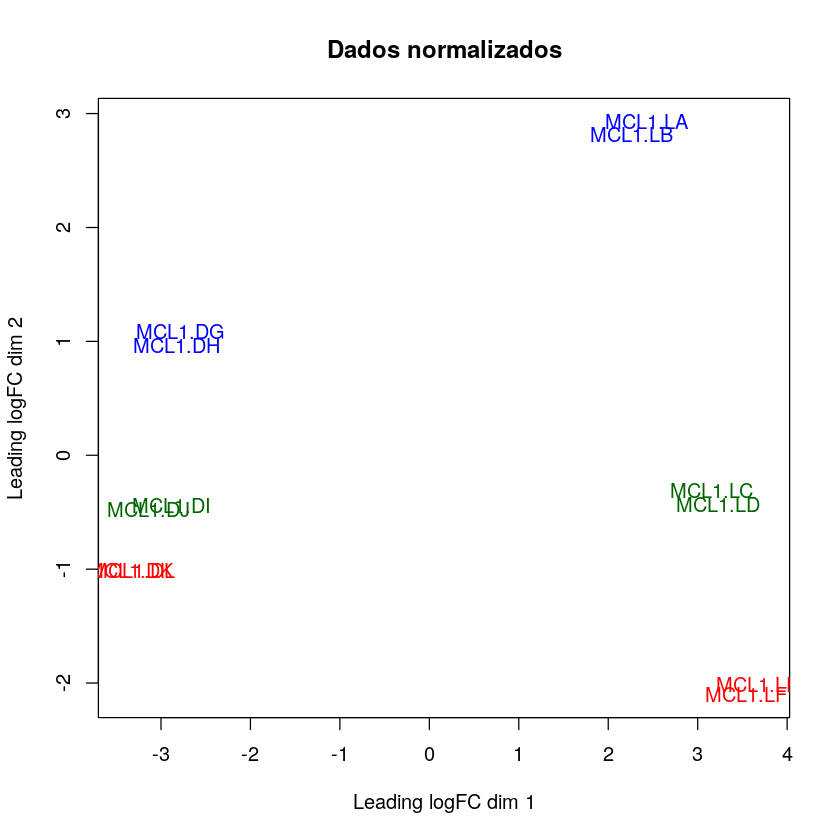

In [45]:
dgList_filtrada <- calcNormFactors(dgList_filtrada, method="TMM") # normalizacao com TMM
# Plot para visualizar os dados nomalizados
par(mfrow=c(1,1))
colors <- rep(c("darkgreen", "red", "blue"), 2)
plotMDS(dgList_filtrada, col=colors[dgList_filtrada$samples$group])
title("Dados normalizados")

# Passo 09: Expressão diferencial

Aqui, o primeiro passo será criar uma matriz com o desenho do experimento.
Em seguida uma matriz de contraste entre os doois casos que analisaremos: basal lactante e basal grávida.
Depois disso, será possível calcular a dispersão e a distribuição binomial negativa, o que nos dará a taxa de *false discovery rate* (FDR).

In [46]:
# Desenho da matriz com os dados de forma que eles repreentem o experimento
desenho_do_experimento <- model.matrix(~ 0 + group)
colnames(desenho_do_experimento) <- levels(dgList_filtrada$samples$group)
desenho_do_experimento

basal.gravida,basal.lactante,basal.virgem,luminal.gravida,luminal.lactante,luminal.virgem
0,0,1,0,0,0
0,0,0,0,0,1
0,0,0,1,0,0
0,0,0,1,0,0
0,0,0,0,1,0
0,0,0,0,1,0
0,0,0,0,0,1
0,0,1,0,0,0
1,0,0,0,0,0
1,0,0,0,0,0


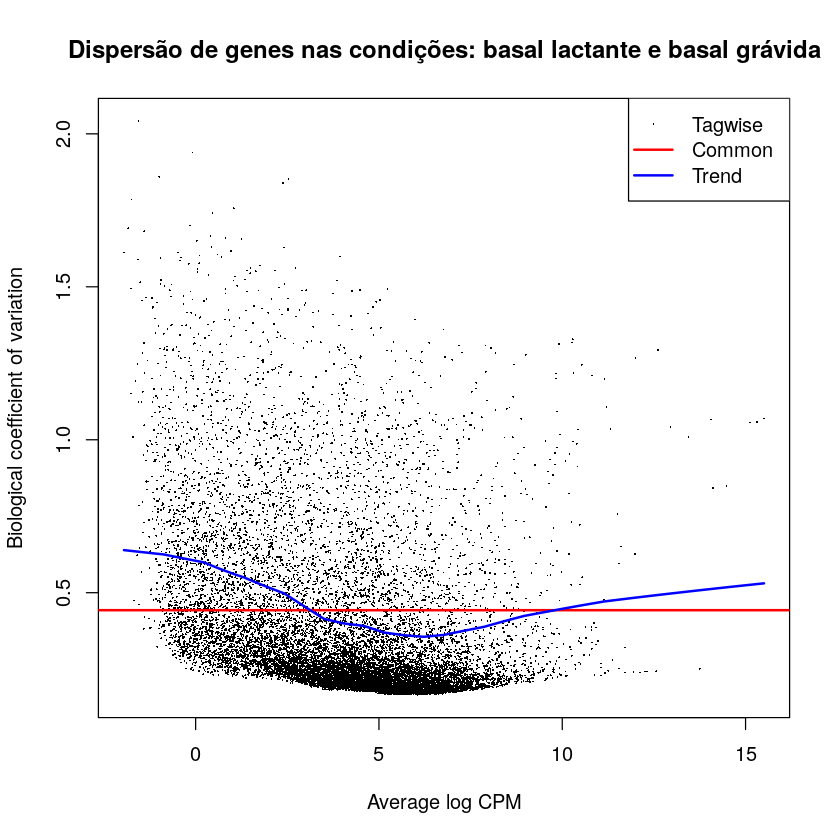

In [50]:
# Exemplo: contraste entre basal lactante e basal grávida
matriz_de_contraste <- makeContrasts(basal.lactante-basal.gravida, levels=desenho_do_experimento)
# Calcular a dispersao
dgList_filtrada <- estimateDisp(dgList_filtrada, desenho_do_experimento, robust=TRUE)
plotBCV(dgList_filtrada)
title("Dispersão de genes nas condições: basal lactante e basal grávida")

,ENTREZID,SYMBOL,GENENAME,logFC,logCPM,F,PValue,FDR
13645,13645,Egf,epidermal growth factor,5.361744,3.829733,743.4969,5.259573e-09,7.728942e-05
13358,13358,Slc25a1,"solute carrier family 25 (mitochondrial carrier, citrate transporter), member 1",4.138133,7.502629,473.0680,2.993017e-08,1.836789e-04
22051,22051,Trip6,thyroid hormone receptor interactor 6,-2.335107,5.845660,446.0500,3.749825e-08,1.836789e-04
11941,11941,Atp2b2,"ATPase, Ca++ transporting, plasma membrane 2",7.372591,6.623890,380.6524,7.157124e-08,2.111141e-04
72027,72027,Slc39a4,"solute carrier family 39 (zinc transporter), member 4",-4.334606,4.264431,362.5695,8.283912e-08,2.111141e-04
74051,74051,Steap2,six transmembrane epithelial antigen of prostate 2,3.237002,4.940290,358.8140,8.619834e-08,2.111141e-04
11416,11416,Slc33a1,"solute carrier family 33 (acetyl-CoA transporter), member 1",2.613230,4.715439,309.8140,1.508570e-07,3.061273e-04
64291,64291,Osbpl1a,oxysterol binding protein-like 1A,2.554938,6.108691,301.8088,1.666566e-07,3.061273e-04
213006,213006,Mfsd4a,major facilitator superfamily domain containing 4A,2.567247,4.402297,286.8873,2.020840e-07,3.285520e-04
100705,100705,Acacb,acetyl-Coenzyme A carboxylase beta,4.325864,6.597597,276.0288,2.339727e-07,3.285520e-04


       -1*basal.gravida 1*basal.lactante
Down                                1341
NotSig                             12166
Up                                  1188

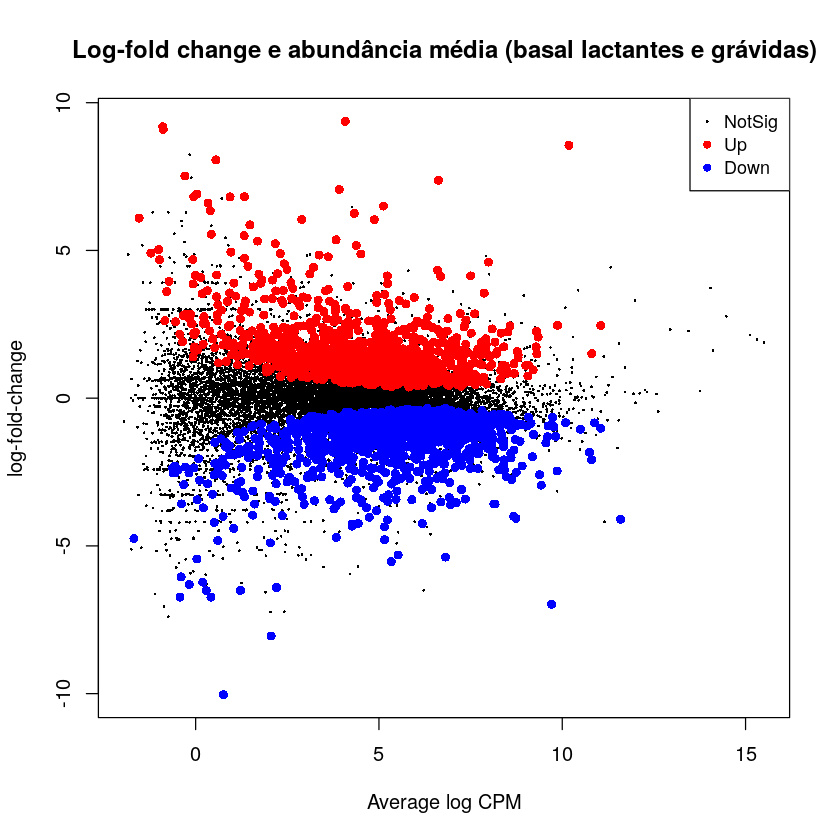

In [52]:
# Calcular a distribuicao negativa binomial com método quasi-likelihood 
fit <- glmQLFit(dgList_filtrada, desenho_do_experimento, robust=TRUE)
res <- glmQLFTest(fit, contrast = matriz_de_contraste)
topTags(res) # mostrar mais representativos
#  genes identificados com false dicovery range (FDR) de até 5% 
genes_fdr_5 <- decideTestsDGE(res)
summary(genes_fdr_5)
plotMD(res, status=genes_fdr_5, main="Log-fold change e abundância média (basal lactantes e grávidas)")